Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# Q.1
np.random.seed(1)
arr = np.random.randint(1,10, size=(30000, 20000))
# %timeit mean_rows = arr.mean(axis=1)
start = time.time()
mean_rows = arr.mean(axis=1)
end = time.time()
duration = end - start
print(f"Time spent computing mean of rows: {duration}")

Time spent computing mean of rows: 0.5512514114379883


In [3]:
# Q.2
import dask.array as da 
da4 = da.from_array(arr, chunks=(1000, 1000))
da4

dask.array<array, shape=(30000, 20000), dtype=int64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [4]:
# Q.3
print(f"size of {da4.nbytes/1024**3:.2f} GB")

chunk = da4[:1000, :1000]
print(f"size of chunk {chunk.nbytes/1024**2:.2f} MB")

"""
As we can see, there is accurate value obtained from manual numpy mehtod 
calculation of size of dask array and chunks
"""


size of 4.47 GB
size of chunk 7.63 MB


'\nAs we can see, there is accurate value obtained from manual numpy mehtod \ncalculation of size of dask array and chunks\n'

Chunk(1000, 1000) | Time 0.5225327014923096
Chunk(3000, 2000) | Time 0.1655418872833252
Chunk(300, 200) | Time 3.520064353942871


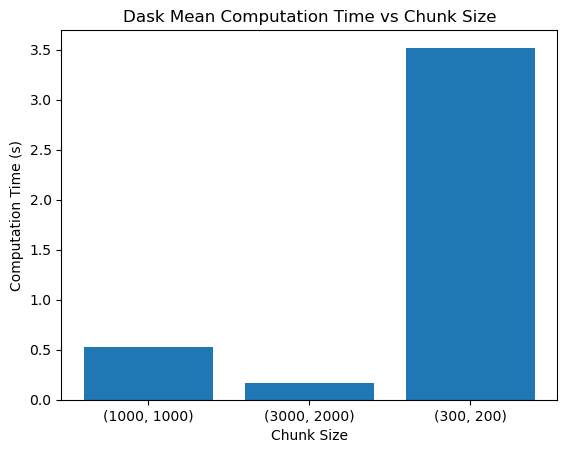

In [5]:
# Q.4
chunks = [(1000, 1000), (3000, 2000), (300, 200)]
times = []
for ch in chunks:
    da_time_compare = da.from_array(arr, chunks=ch)
    start_time = time.time()
    da_time_compare.mean(axis=1).compute()
    end_time = time.time()
    duration = end_time - start_time
    times.append(duration)
    print(f"Chunk{ch} | Time {duration}")

# plotting bin graph 
plt.bar([str(c) for c in chunks], times)
plt.xlabel("Chunk Size")
plt.ylabel("Computation Time (s)")
plt.title("Dask Mean Computation Time vs Chunk Size")
plt.savefig('Part1_Q4.png', dpi=300) 
plt.show() 
   

ANALYSIS:

Larger Chunk few task computation cycles and smaller chunks result in more task computation cyles. 
Each task has overhead such as scheduling, communicating and synchronization.

Larger chunk size results to cores being idle. 
Small chunks do result in more parallel behavior but the slows down due to above mentioned overhead. 

Chunk size of (3000,2000) turns to be sweet spot in this use case since it excecutes the fastest.

In [6]:
del arr,da4,mean_rows,chunk

In [7]:
import gc 
gc.collect()

4510

PART 2

In [8]:
# Q.1
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

data = pd.read_csv('train.csv')

# #features and labels
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

#enconding the class values
if y.dtype == 'object':
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    number_of_classes = len(encoder.classes_)
    

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training the model
model = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=number_of_classes)
start = time.time()
model.fit(X_train, y_train)
end = time.time()
duration = end - start
print(f"Training Time: {duration:.3f} seconds")

#calculating Accuracy 
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

Training Time: 1.634 seconds
Accuracy: 0.998


In [9]:
print(y, number_of_classes)

[0 0 0 ... 8 8 8] 9


n_jobs=1 -> Time : 8.194 seconds
n_jobs=2 -> Time : 4.500 seconds
n_jobs=4 -> Time : 2.700 seconds
n_jobs=8 -> Time : 1.676 seconds


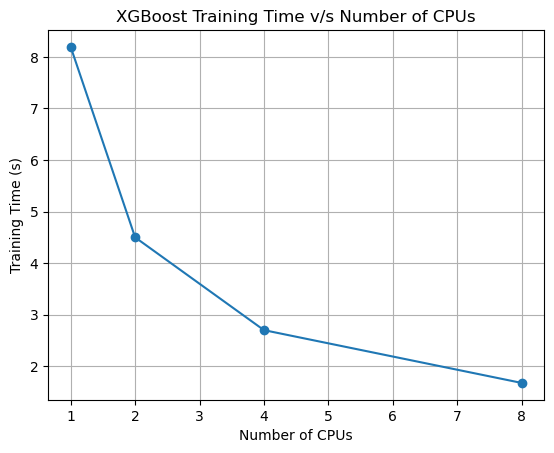

In [10]:
# Q.2
cpus = [1,2,4,8]
times = []

for cpu in cpus:
    model = XGBClassifier(n_jobs=cpu, n_estimators=100, objective='multi:softmax', eval_metric='mlogloss', num_class=number_of_classes)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    duration = end - start
    times.append(duration)
    print(f"n_jobs={cpu} -> Time : {duration:.3f} seconds")

plt.plot(cpus, times, marker='o')
plt.title("XGBoost Training Time v/s Number of CPUs")
plt.xlabel("Number of CPUs")
plt.ylabel("Training Time (s)")
plt.grid(True)
plt.savefig("Part2_Q2.png", dpi=300)
plt.show()

In [11]:
# Q.3
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=False)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.99.101.149:8787/status,
Dashboard: http://10.99.101.149:8787/status,Workers: 4
Total threads: 4,Total memory: 128.00 GiB
Status: running,Using processes: False
Comm: inproc://10.99.101.149/2993389/1,Workers: 0
Dashboard: http://10.99.101.149:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.99.101.149/2993389/4,Total threads: 1
Dashboard: http://10.99.101.149:40675/status,Memory: 32.00 GiB
Nanny: None,


In [12]:
import gc
client.close()
client.shutdown()
cluster.close()

del client, cluster
gc.collect()

1715

In [13]:
# Q.4
import dask.dataframe as dpd
import xgboost.dask as dxgb
import dask.array as da

from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=False)
client = Client(cluster)

d_train = dxgb.DaskDMatrix(client, da.from_array(X_train.values, chunks='auto'), da.from_array(y_train, chunks='auto'))

start = time.time()

dask_model = dxgb.train(client,
                        {'objective': 'multi:softmax', 'eval_metric': 'mlogloss', 'num_class': number_of_classes},
                        d_train,
                       )

end = time.time()
duration = end - start 
print(f"Dask-XGBoost Training Time: {duration:.3f} seconds")

/home/dudhasagare.a/.conda/envs/assignment/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 35.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
[23:11:25] Task [xgboost.dask-0]:inproc://10.99.101.149/2993389/17 got rank 0


Dask-XGBoost Training Time: 1.030 seconds


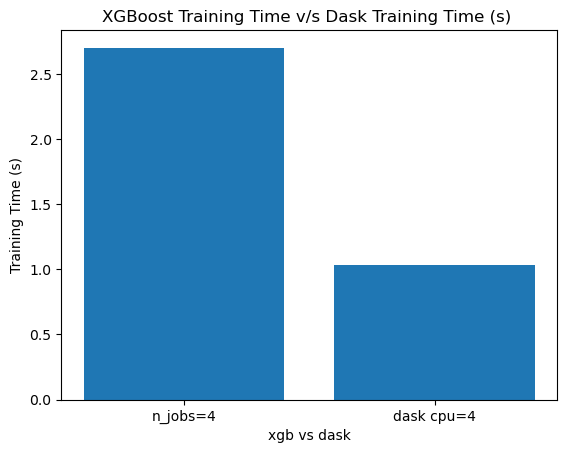

In [14]:
plt.bar(["n_jobs=4", "dask cpu=4"], [times[2], duration])
plt.title("XGBoost Training Time v/s Dask Training Time (s) ")
plt.xlabel("xgb vs dask")
plt.ylabel("Training Time (s)")
plt.savefig("Part2_Q4.png", dpi=300)
plt.show()

In [15]:
client.close()
client.shutdown()
cluster.close()

In [16]:
import gc
del client, cluster, d_train, X_train, y_train, dask_model, model
gc.collect()

3600

PART 3

In [17]:
# !pip install nycflights13

In [18]:
# Q.1
from nycflights13 import flights
flights.head()

flights_data = flights.dropna(subset=["dep_delay"])
flights_data.tail()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
336765,2013,9,30,2240.0,2245,-5.0,2334.0,2351,-17.0,B6,1816,N354JB,JFK,SYR,41.0,209,22,45,2013-10-01T02:00:00Z
336766,2013,9,30,2240.0,2250,-10.0,2347.0,7,-20.0,B6,2002,N281JB,JFK,BUF,52.0,301,22,50,2013-10-01T02:00:00Z
336767,2013,9,30,2241.0,2246,-5.0,2345.0,1,-16.0,B6,486,N346JB,JFK,ROC,47.0,264,22,46,2013-10-01T02:00:00Z
336768,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,B6,718,N565JB,JFK,BOS,33.0,187,22,55,2013-10-01T02:00:00Z
336769,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,745,N516JB,JFK,PSE,196.0,1617,23,59,2013-10-01T03:00:00Z


In [19]:
from dask.distributed import Client,LocalCluster

cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=False)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.99.101.149:8787/status,
Dashboard: http://10.99.101.149:8787/status,Workers: 4
Total threads: 4,Total memory: 128.00 GiB
Status: running,Using processes: False
Comm: inproc://10.99.101.149/2993389/32,Workers: 0
Dashboard: http://10.99.101.149:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.99.101.149/2993389/35,Total threads: 1
Dashboard: http://10.99.101.149:43697/status,Memory: 32.00 GiB
Nanny: None,


In [20]:
import dask.dataframe as dd
ddf = dd.from_pandas(flights_data, npartitions=8)
ddf.head()

/home/dudhasagare.a/.conda/envs/assignment/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 44.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T10:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T10:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T10:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T10:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T11:00:00Z


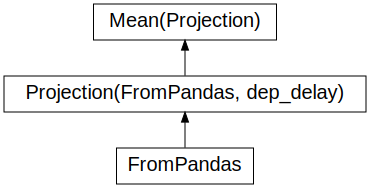

In [21]:
mean_delay = ddf['dep_delay'].mean()
mean_delay.visualize(filename="mean_dep_delay_taskgraph.svg")

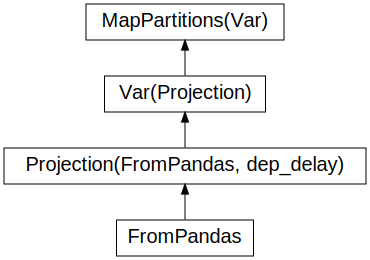

In [22]:
std_dev_delay = ddf['dep_delay'].std()
std_dev_delay.visualize(filename="std_dev_dep_delay_taskgraph.svg")

In [23]:
from dask.distributed import performance_report
import dask

with performance_report(filename="dask-report.html"):
    mean, std = dask.compute(mean_delay, std_dev_delay)

print(f"Time to Compute Dask Mean : {mean:.3f} seconds")
print(f"Time to Compute Dask Standard Deviation : {std:.3f} seconds")

/home/dudhasagare.a/.conda/envs/assignment/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 44.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Time to Compute Dask Mean : 12.639 seconds
Time to Compute Dask Standard Deviation : 40.210 seconds


In [24]:
client.close()
client.shutdown()
cluster.close()